In [1]:
%matplotlib inline
# File formats
import ROOT
import uproot, h5py, pickle
# Data manipulation
import datetime as dt
import numpy as np
import pandas as pd
# Plotting
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
from matplotlib.patches import Polygon
# Others
from tqdm.notebook import tqdm
import sys, importlib
from importlib import reload
from pathlib import Path
# Personal
import hepkit.hepData as hd
import hepkit.hepIO as hio
import hepkit.hepPlot as hp
import hepkit.hepFormat as hf
# Colors
mc = [
    [35/255,55/255,59/255],
    [237/255,138/255,46/255],
    [131/255,40/255,0/255],
    [0/255,123/255,68/255],
    [107/255,60/255,79/255],
    [118/255,93/255,68/255],
    [62/255,79/255,51/255],
    [147/255,161/255,161/255]
]


# Add current directory to import path and import locals
pathFromHere = Path("__file__").parent.absolute()
sys.path.insert(1, pathFromHere)
import Libraries.charge_library as cl
import Libraries.light_library as ll
import Libraries.light_class as llc
import Libraries.meta_library as ml
import Libraries.evd_library as evd
import Libraries.protonCandidate_class as pcc
import Libraries.betheBloch_library as bbl

hf.DefaultSetup()

Welcome to JupyROOT 6.22/08


In [2]:
%%time
reload(cl)
reload(ll)

### FILENAMES
cpath = '/home/dporzio/Data/Michel/michel_datalog_2021_04_04_16_19_13_CEST_evd.h5'
ldir = '/home/dporzio/Data/Michel'

### LOAD LIGHT DATA
# Uproot
ldata, lpath = ml.FindPartnerLightFile(cpath,ldir)
# Root
rfile = ROOT.TFile.Open(lpath, 'read')
rwf = rfile.Get('rwf')
# Convert utime to a better usable format
ldata['utime_ms'] = ldata['utime_ms'].astype(np.int64)

### LOAD CHARGE DATA
cdata = h5py.File(cpath,'r')

h_events = cdata['events']
h_trigs = cdata['ext_trigs']
h_tracks = cdata['tracks']
h_hits = cdata['hits']
h_info = cdata['info'].attrs

print("events:",[t for t in cdata['events'].dtype.names])
print("tracks:",[t for t in cdata['tracks'].dtype.names])
print("hits:",[t for t in cdata['hits'].dtype.names])
print("ext_trigs:",[t for t in cdata['ext_trigs'].dtype.names])
print("info:",[t for t in (cdata['info'].attrs).keys()])

### LOAD GEOMETRY DATA
geometryHelper = cl.GetGeometryHelper(h_info)

### OTHER FUNCTIONS
def EuDistance(p1,p2):
    return np.sqrt(np.power(p1[0]-p2[0],2.) + np.power(p1[1]-p2[1],2.) + np.power(p1[2]-p2[2],2.))

Charge file 2021_04_04_16_19_13 has been matched to light file ['20210404_161914.data'].
events: ['evid', 'track_ref', 'hit_ref', 'nhit', 'q', 'ts_start', 'ts_end', 'ntracks', 'ext_trig_ref', 'n_ext_trigs', 'unix_ts', 'q_raw']
tracks: ['track_id', 'event_ref', 'hit_ref', 'theta', 't0', 'phi', 'xp', 'yp', 'nhit', 'q', 'ts_start', 'ts_end', 'residual', 'length', 'start', 'end', 'q_raw', 't0_type']
hits: ['hid', 'px', 'py', 'ts', 'q', 'iochannel', 'iogroup', 'chipid', 'channelid', 'geom', 'event_ref', 'q_raw']
ext_trigs: ['trig_id', 'event_ref', 'ts', 'type']
info: ['clock_period', 'configuration_file', 'electron_lifetime_file', 'geometry_file', 'pedestal_file', 'source_file', 'vdrift']
CPU times: user 3.93 s, sys: 1.67 s, total: 5.6 s
Wall time: 6.24 s


In [3]:
### CREATE LIST OF GOOD EVENTS
# Consider good events all events that have max 10 tracks
# And that have an external trigger
sel_maxTracksInEv = 5
sel_minTracksInEv = 0

bool_tracks = (h_events['ntracks'] <= sel_maxTracksInEv) & (h_events['ntracks'] >= sel_minTracksInEv)
bool_trigger = h_events['n_ext_trigs'] > 0
goodEvs = h_events[(bool_tracks & bool_trigger)]
print(len(goodEvs))

91643


In [4]:
data = {
    'evid': [],
    'ts': [],
    'dtts': [],
    'tref': [],
    'bary_x': [],
    'bary_y': [],
    'bary_z': [],
    'bary_x_std': [],
    'bary_y_std': [],
    'bary_z_std': [],
    'bary_max_plane_std': [],
    'bary_max_3d_std': [],
    'tpc': []
}
### FIND CANDIDATE EVENTS
for ev in tqdm(goodEvs[0:60000]):
    # Find all the hits in the event and get proper z-coordinates
    evid = ev['evid']
    ts = ev['unix_ts']
    dtts = dt.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    tref = cl.GetEventStartTime(evid,cdata)
    myHits = cdata['hits'][ev['hit_ref']]
    tref = cl.GetEventStartTime(evid,cdata)
    z_hits = [cl.ConvertTimeToZ(geometryHelper, io_group, io_channel, time, tref) for io_group, io_channel, time in zip(myHits['iogroup'], myHits['iochannel'], myHits['ts'])]
    # Get physical qs (we don't need negative values)
    physical_q = np.where(myHits['q']>0,myHits['q'],0)
    q_weights = physical_q/physical_q.sum()
    # Find the barycenter position
    bary_x = (np.array([x*q_weight for x,q_weight in zip(myHits['px'],q_weights)]).sum())
    bary_y = (np.array([x*q_weight for x,q_weight in zip(myHits['py'],q_weights)]).sum())
    bary_z = (np.array([x*q_weight for x,q_weight in zip(z_hits,q_weights)]).sum())
    # Determine the error on barycenter position
    bary_x_std = np.sqrt(np.array([np.power(x-bary_x,2.)*q_weight for x,q_weight in zip(myHits['px'],q_weights)]).sum())
    bary_y_std = np.sqrt(np.array([np.power(x-bary_y,2.)*q_weight for x,q_weight in zip(myHits['py'],q_weights)]).sum())
    bary_z_std = np.sqrt(np.array([np.power(x-bary_z,2.)*q_weight for x,q_weight in zip(z_hits,q_weights)]).sum())
    # Find the TPC and print a distance score
    tpc = 1 if bary_z < 0 else 2
    data['evid'].append(evid)
    data['ts'].append(ts)
    data['dtts'].append(dtts)
    data['tref'].append(tref)
    data['bary_x'].append(bary_x)
    data['bary_y'].append(bary_y)
    data['bary_z'].append(bary_z)
    data['bary_x_std'].append(bary_x_std)
    data['bary_y_std'].append(bary_y_std)
    data['bary_z_std'].append(bary_z_std)
    data['bary_max_plane_std'].append(np.max((bary_x_std,bary_y_std)))
    data['bary_max_3d_std'].append(np.max((bary_x_std,bary_y_std,bary_z_std)))
    data['tpc'].append(tpc)

# Pandify data
df = pd.DataFrame(data)

  0%|          | 0/60000 [00:00<?, ?it/s]

/home/dporzio/.conda/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


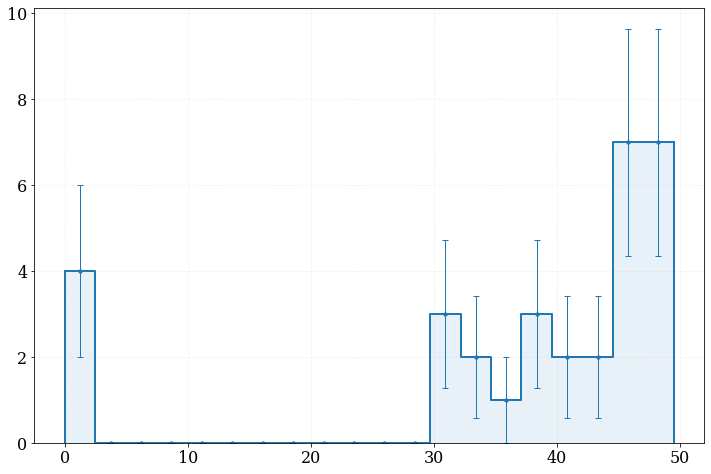

In [38]:
tdf = df.query('bary_max_3d_std<50')
tdf = tdf.query('bary_x>-100 & bary_x<100')
hp.HepHist(tdf['bary_max_3d_std'],nbins=20)
plt.show()

In [7]:
reload(llc)
reload(ll)
goodCandidates = []
allCandidates = []
for i in tqdm(range(len(tdf))):
    ldf = ll.GetEventMetadata(ldata,lpath,tdf.iloc[i]['evid'],tdf.iloc[i]['dtts'],tdf.iloc[i]['tref']/10,window_us=100,verbose=False)
    allCandidates.append(ldf.nChannels_ADC)
    if (ldf.nChannels_ADC[0]!=0 & ldf.nChannels_ADC[1]!=0):
        goodCandidates.append(i)

  0%|          | 0/237 [00:00<?, ?it/s]

Searching Busy at 2021-04-04 14:22:20, with 743422.3 us offset, in a 50 us-wide window.

- Found following channels for ADC 1 (Mult. 58)
|_ [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 34 35 36 37 38 39 40 41 42 43 44 45 46 47 50 51 52 53
 54 55 56 57 58 59 60 61 62 63]
- Found following channels for ADC 2 (Mult. 58)
|_ [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 34 35 36 37 38 39 40 41 42 43 44 45 46 47 50 51 52 53
 54 55 56 57 58 59 60 61 62 63]

Offset: 743422.3 us
t0_ADCs: [743422.49 | 743422.43] us
Jitter w.: [0.18999999994412065 | 0.1300000000046566] ns

Found busy front on ADC 1 (175780172), at 1200 ns.
Found busy front on ADC 2 (175854781), at 1230 ns.
TPC: 2
-35.0 +- 14.2
504.2 +- 30.0
17.6 +- 23.4


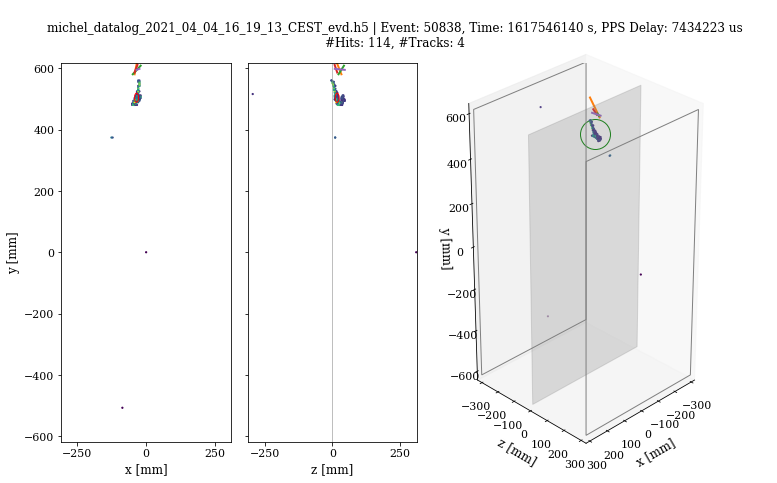

{1: 1.1315998187174257, 2: 3.907982261640798}


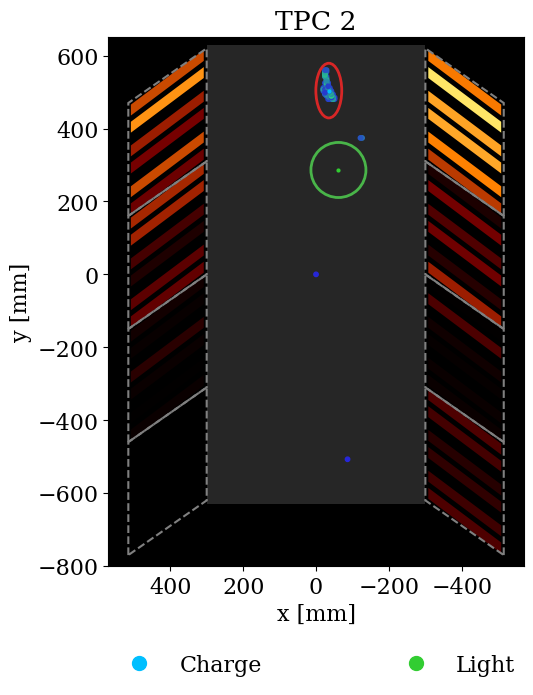

In [48]:
# Manually pick an event
i = 9
reload(llc)
reload(ll)
# tr = int(cdata['ext_trigs'][cdata['events'][evid]['ext_trig_ref']]['ts'][1])
# ldf = ll.GetEventMetadata(ldata,lpath,df.iloc[i]['id_eventId'],df.iloc[i]['ev_dtts'],tr/10,window_us=1000)
ldf = ll.GetEventMetadata(ldata,lpath,tdf.iloc[i]['evid'],tdf.iloc[i]['dtts'],tdf.iloc[i]['tref']/10,window_us=50)


# Find all useful metainformation regarding the event
evid = int(tdf.iloc[i]['evid'])
myHits = cdata['hits'][cdata['events'][evid]['hit_ref']]
tref = cl.GetEventStartTime(evid,cdata)
z_hits = [cl.ConvertTimeToZ(geometryHelper, io_group, io_channel, time, tref) for io_group, io_channel, time in zip(myHits['iogroup'], myHits['iochannel'], myHits['ts'])]
tpc = tdf.iloc[i]['tpc']


bary_x = tdf.iloc[i]['bary_x']
bary_y = tdf.iloc[i]['bary_y']
bary_z = tdf.iloc[i]['bary_z']
bary_x_std = tdf.iloc[i]['bary_x_std']
bary_y_std = tdf.iloc[i]['bary_y_std']
bary_z_std = tdf.iloc[i]['bary_z_std']




# PLOT TO AID VISUALIZATION, NOT NECESSARY FOR RUNNING CODE
print(f"TPC: {tpc}")
print(f"{bary_x:.1f} +- {bary_x_std:.1f}")
print(f"{bary_y:.1f} +- {bary_y_std:.1f}")
print(f"{bary_z:.1f} +- {bary_z_std:.1f}")

reload(evd)
fig,ax1,ax2,ax3 = evd.SmallEventDisplay(evid,cpath,cdata,geometryHelper,rot=45,showTracks=True,xTrackOffset=0,yTrackOffset=100)
ax1.add_patch(Ellipse((tdf.iloc[i]['bary_x'],tdf.iloc[i]['bary_y']),width=tdf.iloc[i]['bary_x_std'],height=tdf.iloc[i]['bary_y_std'],facecolor='None',edgecolor='red'))
ax2.add_patch(Ellipse((tdf.iloc[i]['bary_z'],tdf.iloc[i]['bary_y']),width=tdf.iloc[i]['bary_x_std'],height=tdf.iloc[i]['bary_y_std'],facecolor='None',edgecolor='red'))
ax3.plot(tdf.iloc[i]['bary_x'],tdf.iloc[i]['bary_z'],tdf.iloc[i]['bary_y'],marker='o',markersize=30,markeredgecolor='green',markerfacecolor='None')
plt.show()

reload(llc)

max_i = {1: 0, 2: 0}
integs = {
    1: {},
    2: {},
}

for sn in llc.viable_sn:
    for ch in llc.viable_ch:
        th = ldf.hist_h[sn][ch]
        if th!=None:
            trel = ldf.t_rel[sn][ch]
            gain = llc.channelInfo[sn][ch][9] # Gain
            l_tpc = llc.channelInfo[sn][ch][3]
            x = np.linspace(trel,trel+len(th)*10,len(th))
            baseline = np.mean(th[0:80])
            th = th - baseline

            left = (np.abs(x - 0)).argmin()
            right = (np.abs(x - 500)).argmin()
            if gain>0: integ = np.abs(np.sum(th[left:right]))/(64.0*gain)
            else: integ = 0

            if integ>max_i[l_tpc]: max_i[l_tpc] = integ
            integs[sn][ch] = integ
        
# plt.plot(x,th)
# plt.axvline(x[left],c='r')
# plt.axvline(x[right],c='r')
# plt.axvline(x[80],c='g')
# plt.show()
# print(integ)
print(max_i)

xs,ys,qs = [], [], []
for sn in llc.viable_sn:
    for ch in llc.viable_ch:
        pm_x = llc.channelInfo[sn][ch][0]
        pm_y = llc.channelInfo[sn][ch][1]
        pm_tpc = llc.channelInfo[sn][ch][3]
        pm_l = integs[sn][ch]
        if pm_tpc==tpc:
            xs.append(pm_x)
            ys.append(pm_y)
            qs.append(pm_l)

xs = np.array(xs)
ys = np.array(ys)
qs = np.array(qs)
            
q_weights = qs/qs.sum()
lbary_x = (np.array([x*q_weight for x,q_weight in zip(xs,q_weights)]).sum())
lbary_y = (np.array([x*q_weight for x,q_weight in zip(ys,q_weights)]).sum())
# Determine the error on barycenter position
lbary_x_std = np.sqrt(np.array([np.power(x-lbary_x,2.)*q_weight for x,q_weight in zip(xs,q_weights)]).sum())
lbary_y_std = np.sqrt(np.array([np.power(x-lbary_y,2.)*q_weight for x,q_weight in zip(ys,q_weights)]).sum())



from matplotlib.patches import Rectangle
from matplotlib import cm
cmap = cm.afmhot
alpha = 1



fig, ax = plt.subplots(figsize=(14,7),facecolor='white',dpi=100)
for sn in llc.viable_sn:
    for ch in llc.viable_ch:
        x,y,l_tpc = llc.channelInfo[sn][ch][0],llc.channelInfo[sn][ch][1],llc.channelInfo[sn][ch][3]
        if l_tpc==tpc:
            integ = integs[sn][ch]
            color = cmap((integ/float(max_i[l_tpc]))*0.7)
            xsign = x/abs(x)
            xs = [x,x,x+xsign*200,x+xsign*200]
            ys = [y-15,y+15,y+15-150,y-15-150]
            pl = Polygon(xy=list(zip(xs,ys)), fill=True, facecolor=color, alpha=alpha)
            ax.add_patch(pl)
            
            
myHits = cdata['hits'][cdata['events'][evid]['hit_ref']]
cmap = plt.cm.get_cmap('winter')
norm = matplotlib.colors.Normalize(vmin=0,vmax=200, clip=True)
ax.scatter(myHits['px'],myHits['py'],c=cmap(norm(myHits['q'])),s=10)
ax.plot(-1e10,-1e10,ls='None',marker='o',markersize=10,color='deepskyblue',label='Charge')
ax.plot(-1e5,-1e5,ls='None',marker='o',markersize=10,color='limegreen',label='Light')
ax.plot(bary_x,bary_y,marker='o',markersize=2,color='deepskyblue')
ax.plot(lbary_x,lbary_y,marker='o',markersize=2,color='limegreen')
ax.add_patch(Ellipse((bary_x,bary_y),width=bary_x_std*5.,height=bary_y_std*5.,facecolor='None',edgecolor='red',linewidth=2))
ax.add_patch(Ellipse((lbary_x,lbary_y),width=lbary_x_std/2.,height=lbary_y_std/2.,facecolor='None',edgecolor='limegreen',linewidth=2))

# Draw the readout
xs = [-300,-300,300,300]
ys = [-630,630,630,-630]
pl = Polygon(xy=list(zip(xs,ys)), fill=True, facecolor='gray', alpha=0.3)
ax.add_patch(pl)

    
if(tpc==1): plt.xlim(-570,570)
if(tpc==2): plt.xlim(570,-570)


plt.ylim(-800,650)
# plt.axvline(0,ls='--',color='gray')
# plt.axhline(310.2,ls='--',color='gray')
# plt.axhline(0,ls='--',color='gray')
# plt.axhline(-310.2,ls='--',color='gray')

tile_centers_x, tile_centers_y = [-300,-300,-300,-300,300,300,300,300], [465.2,155.2,-155.2,-465.2,465.2,155.2,-155.2,-465.2]
y_width = 155
for tc_x, tc_y in zip(tile_centers_x,tile_centers_y):
    norm = tc_x/abs(tc_x)
    xs = [tc_x+norm*215,tc_x+norm*215,tc_x,tc_x]
    ys = [tc_y-150-y_width,tc_y-150+y_width,tc_y+y_width,tc_y-y_width]
    pl = Polygon(xy=list(zip(xs,ys)), fill=None, linestyle='--', edgecolor='gray', linewidth=1.5, alpha=1)
    ax.add_patch(pl)


plt.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0, frameon=False)
plt.title(f'TPC {tpc}')


ax.set_facecolor('black')
ax.set_aspect('equal')

plt.xlabel('x [mm]')
plt.ylabel('y [mm]')




plt.show()




{1: 2.452294997421351, 2: 62.89805395842548}


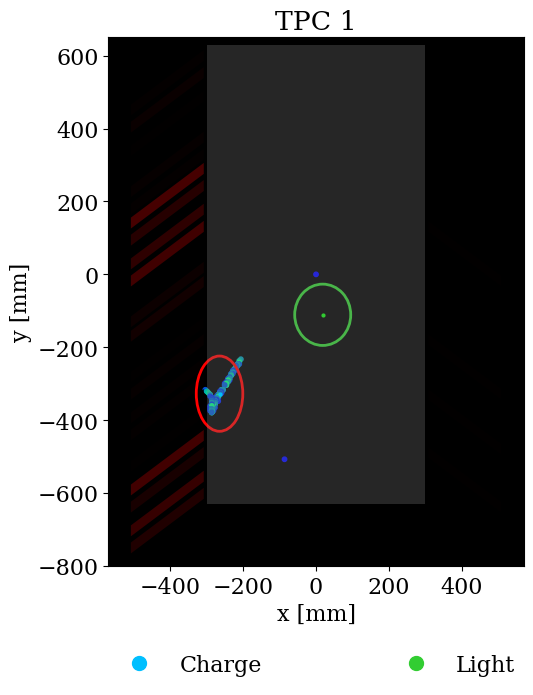

In [189]:
reload(llc)

max_i = {1: 0, 2: 0}
integs = {
    1: {},
    2: {},
}

for sn in llc.viable_sn:
    for ch in llc.viable_ch:
        th = ldf.hist_h[sn][ch]
        if th!=None:
            trel = ldf.t_rel[sn][ch]
            gain = llc.channelInfo[sn][ch][9] # Gain
            x = np.linspace(trel,trel+len(th)*10,len(th))
            baseline = np.mean(th[0:80])
            th = th - baseline

            left = (np.abs(x - 0)).argmin()
            right = (np.abs(x - 500)).argmin()
            if gain>0: integ = np.abs(np.sum(th[left:right]))/(64.0*gain)
            else: integ = 0

            if integ>max_i[sn]: max_i[sn] = integ
            integs[sn][ch] = integ
        
# plt.plot(x,th)
# plt.axvline(x[left],c='r')
# plt.axvline(x[right],c='r')
# plt.axvline(x[80],c='g')
# plt.show()
# print(integ)
print(max_i)

xs,ys,qs = [], [], []
for sn in llc.viable_sn:
    for ch in llc.viable_ch:
        pm_x = llc.channelInfo[sn][ch][0]
        pm_y = llc.channelInfo[sn][ch][1]
        pm_tpc = llc.channelInfo[sn][ch][3]
        pm_l = integs[sn][ch]
        if pm_tpc==tpc:
            xs.append(pm_x)
            ys.append(pm_y)
            qs.append(pm_l)

xs = np.array(xs)
ys = np.array(ys)
qs = np.array(qs)
            
q_weights = qs/qs.sum()
lbary_x = (np.array([x*q_weight for x,q_weight in zip(xs,q_weights)]).sum())
lbary_y = (np.array([x*q_weight for x,q_weight in zip(ys,q_weights)]).sum())
# Determine the error on barycenter position
lbary_x_std = np.sqrt(np.array([np.power(x-lbary_x,2.)*q_weight for x,q_weight in zip(xs,q_weights)]).sum())
lbary_y_std = np.sqrt(np.array([np.power(x-lbary_y,2.)*q_weight for x,q_weight in zip(ys,q_weights)]).sum())



from matplotlib.patches import Rectangle
from matplotlib import cm
cmap = cm.afmhot
alpha = 1



fig, ax = plt.subplots(figsize=(14,7),facecolor='white',dpi=100)
for sn in llc.viable_sn:
    for ch in llc.viable_ch:
        x,y,l_tpc = llc.channelInfo[sn][ch][0],llc.channelInfo[sn][ch][1],llc.channelInfo[sn][ch][3]
        if l_tpc==tpc:
            integ = integs[sn][ch]
            color = cmap((integ/float(max_i[sn]))*0.8)
            xsign = x/abs(x)
            xs = [x,x,x+xsign*200,x+xsign*200]
            ys = [y-15,y+15,y+15-150,y-15-150]
            pl = Polygon(xy=list(zip(xs,ys)), fill=True, facecolor=color, alpha=alpha)
            ax.add_patch(pl)
            
            
myHits = cdata['hits'][cdata['events'][evid]['hit_ref']]
cmap = plt.cm.get_cmap('winter')
norm = matplotlib.colors.Normalize(vmin=0,vmax=200, clip=True)
ax.scatter(myHits['px'],myHits['py'],c=cmap(norm(myHits['q'])),s=10)
ax.plot(-1e10,-1e10,ls='None',marker='o',markersize=10,color='deepskyblue',label='Charge')
ax.plot(-1e5,-1e5,ls='None',marker='o',markersize=10,color='limegreen',label='Light')
ax.plot(bary_x,bary_y,marker='o',markersize=2,color='deepskyblue')
ax.plot(lbary_x,lbary_y,marker='o',markersize=2,color='limegreen')
ax.add_patch(Ellipse((bary_x,bary_y),width=bary_x_std*5.,height=bary_y_std*5.,facecolor='None',edgecolor='red',linewidth=2))
ax.add_patch(Ellipse((lbary_x,lbary_y),width=lbary_x_std/2.,height=lbary_y_std/2.,facecolor='None',edgecolor='limegreen',linewidth=2))

# Draw the readout
xs = [-300,-300,300,300]
ys = [-630,630,630,-630]
pl = Polygon(xy=list(zip(xs,ys)), fill=True, facecolor='gray', alpha=0.3)
ax.add_patch(pl)

    
plt.xlim(-570,570)
plt.ylim(-800,650)
# plt.axvline(0,ls='--',color='gray')
# plt.axhline(310.2,ls='--',color='gray')
# plt.axhline(0,ls='--',color='gray')
# plt.axhline(-310.2,ls='--',color='gray')

plt.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0, frameon=False)
plt.title(f'TPC {l_tpc}')



ax.set_facecolor('black')
ax.set_aspect('equal')

plt.xlabel('x [mm]')
plt.ylabel('y [mm]')




plt.show()



In [4]:
reload(bbl)
reload(pcc)

### Edges selection
sel_xEdge = np.array([-308,308])
sel_yEdge = np.array([-618,618])
sel_zEdge = np.array([-315,315])
sel_xPadding = np.array([30,-30])
sel_yPadding = np.array([30,-30])
sel_zPadding = np.array([30,-30])
sel_xLim = sel_xEdge + sel_xPadding
sel_yLim = sel_yEdge + sel_yPadding
sel_zLim = sel_zEdge + sel_zPadding
# Track length selection
sel_minTrackLength = 3 # cm. Minimum length of proton candidate track
sel_maxTrackLength = 15 # cm. Maximum length of proton candidate track
### dEdx selection
sel_dedxAveBin = 1 # cm. Length of bin to add together dEdx
sel_mindedx_end = 2 # MeV/cm. Minimum dedx at the end of proton candidate track
sel_maxdedx_start = 1 # MeV/cm. Maximum dedx at the start of proton candidate track

conversionFactor = 245 # #e-/mv, q is in mv, which corresponds to 245 electrons
rmodel = 'box' # Recombination model


protons = []
# Loop through each event of the good event list
for ev in tqdm(goodEvs[0:60000]):
    # For each event, get a list of all the tracks
    tracks = h_tracks[ev['track_ref']]
    # First condition, longest track in event must still be less than max length
    maxLength = max([tracks[i]['length'] for i in range(len(tracks))])
    if maxLength/10>sel_maxTrackLength:
        continue
    # Otherwise, longest track is our candidate
    longTrackArg = np.argmax(np.array([tracks[i]['length'] for i in range(len(tracks))]))
    track = tracks[longTrackArg]
    
    
    # Let's get event id and track id and create the candidate
    evid = ev['evid']
    trid = track['track_id']
    proton = pcc.ProtonCandidate(evid,trid)
    # We get the edge points, we don't make assumptions on which is start and which is end
    p0 = track['start']
    p1 = track['end']

    # First of all get the tref which we need for z-position
    proton.ev_ts = ev['unix_ts']
    proton.ev_dtts = dt.datetime.utcfromtimestamp(proton.ev_ts).strftime('%Y-%m-%d %H:%M:%S')
    proton.ev_tref = cl.GetEventStartTime(evid,cdata)

    # Apply some early selections on length alone
    length = track['length']/10
    if length<sel_minTrackLength or length>sel_maxTrackLength:
        continue
    # And also on containment
    cond_startContainedX = p0[0]>sel_xLim[0] and p0[0]<sel_xLim[1]
    cond_startContainedY = p0[1]>sel_yLim[0] and p0[1]<sel_yLim[1]
    cond_startContainedZ = p0[2]>sel_zLim[0] and p0[2]<sel_zLim[1]
    cond_endContainedX = p1[0]>sel_xLim[0] and p1[0]<sel_xLim[1]
    cond_endContainedY = p1[1]>sel_yLim[0] and p1[1]<sel_yLim[1]
    cond_endContainedZ = p1[2]>sel_zLim[0] and p1[2]<sel_zLim[1]
    cond_contained = cond_startContainedX and cond_endContainedX \
                    and cond_startContainedY and cond_endContainedY \
                    and cond_startContainedZ and cond_endContainedZ
    if not cond_contained:
        continue

    protons.append(proton)
        
print(f"Found {len(protons)} short tracks out of {len(goodEvs)}")

# Convert list of proton objects to pandas dataframe
df = pd.DataFrame()
attributes = [att for att in dir(protons[0]) if att[0]!='_']
for att in attributes:
    df[att] = [getattr(protons[i],att) for i in range(len(protons))]
        


  0%|          | 0/49435 [00:00<?, ?it/s]

Found 197 short tracks out of 49435


TPC: 1
dScore: 0.8
-215.1 +- 85.4
365.6 +- 175.6
-246.8 +- 135.4


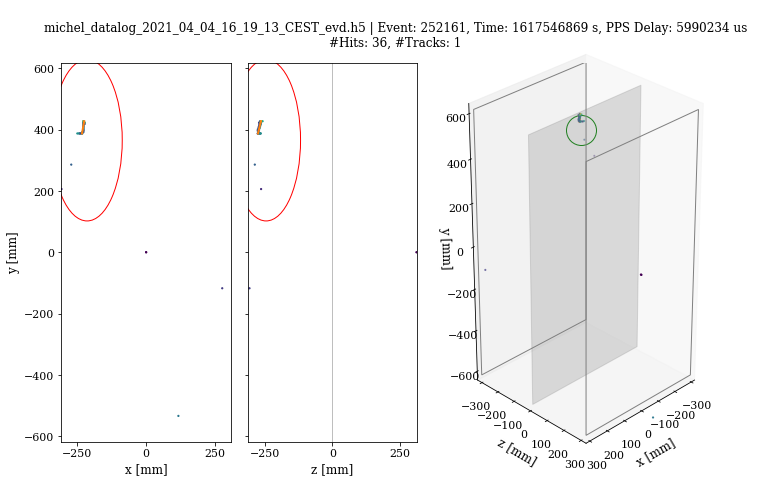

2021-04-04 14:34:29
Searching Busy at 2021-04-04 14:34:29, with 599023.4 us offset, in a 100 us-wide window.

- Found following channels for ADC 1 (Mult. 58)
|_ [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 34 35 36 37 38 39 40 41 42 43 44 45 46 47 50 51 52 53
 54 55 56 57 58 59 60 61 62 63]
- Found following channels for ADC 2 (Mult. 58)
|_ [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 34 35 36 37 38 39 40 41 42 43 44 45 46 47 50 51 52 53
 54 55 56 57 58 59 60 61 62 63]

Offset: 599023.4 us
t0_ADCs: [599023.63 | 599024.02] us
Jitter w.: [0.22999999998137355 | 0.6199999999953434] ns

Found busy front on ADC 1 (175780172), at 1220 ns.
Found busy front on ADC 2 (175854781), at 930 ns.
{1: 7.833042317173377, 2: 2.1845540246555473}


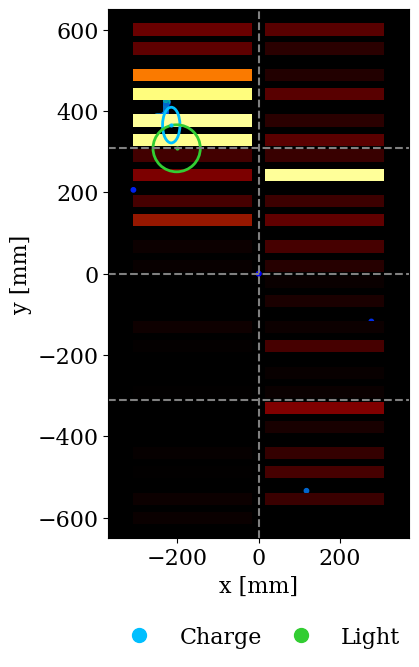

In [517]:
from matplotlib.patches import Ellipse

# Manually pick an event
i = 141

# Find all useful metainformation regarding the event
evid = protons[i].id_eventId
myHits = cdata['hits'][cdata['events'][evid]['hit_ref']]
myTracks = cdata['tracks'][cdata['events'][evid]['track_ref']]
tref = cl.GetEventStartTime(evid,cdata)
z_hits = [cl.ConvertTimeToZ(geometryHelper, io_group, io_channel, time, tref) for io_group, io_channel, time in zip(myHits['iogroup'], myHits['iochannel'], myHits['ts'])]
# Determine charge barycenter of event
physical_q = np.where(myHits['q']>0,myHits['q'],0) # q that make sense (no negative)
# physical_q = np.array(myHits['q'])
q_weights = physical_q/physical_q.sum()
bary_x = (np.array([x*q_weight for x,q_weight in zip(myHits['px'],q_weights)]).sum())
bary_y = (np.array([x*q_weight for x,q_weight in zip(myHits['py'],q_weights)]).sum())
bary_z = (np.array([x*q_weight for x,q_weight in zip(z_hits,q_weights)]).sum())
# Determine the error on barycenter position
bary_x_std = np.sqrt(np.array([np.power(x-bary_x,2.)*q_weight for x,q_weight in zip(myHits['px'],q_weights)]).sum())
bary_y_std = np.sqrt(np.array([np.power(x-bary_y,2.)*q_weight for x,q_weight in zip(myHits['py'],q_weights)]).sum())
bary_z_std = np.sqrt(np.array([np.power(x-bary_z,2.)*q_weight for x,q_weight in zip(z_hits,q_weights)]).sum())
# Find the TPC and print a distance score
tpc = 1 if bary_z < 0 else 2
dScore = 1-(308 - np.abs(bary_z))/308.


# PLOT TO AID VISUALIZATION, NOT NECESSARY FOR RUNNING CODE
print(f"TPC: {tpc}")
print(f"dScore: {dScore:.2}")
print(f"{bary_x:.1f} +- {bary_x_std:.1f}")
print(f"{bary_y:.1f} +- {bary_y_std:.1f}")
print(f"{bary_z:.1f} +- {bary_z_std:.1f}")

reload(evd)
fig,ax1,ax2,ax3 = evd.SmallEventDisplay(evid,cpath,cdata,geometryHelper,rot=45,showTracks=True,xTrackOffset=0,yTrackOffset=0)
ax1.add_patch(Ellipse((bary_x,bary_y),width=bary_x_std*3.,height=bary_y_std*3.,facecolor='None',edgecolor='red'))
ax2.add_patch(Ellipse((bary_z,bary_y),width=bary_x_std*3.,height=bary_y_std*3.,facecolor='None',edgecolor='red'))
ax3.plot(bary_x,bary_z,bary_y,marker='o',markersize=30,markeredgecolor='green',markerfacecolor='None')
plt.show()


reload(llc)
reload(ll)
# tr = int(cdata['ext_trigs'][cdata['events'][evid]['ext_trig_ref']]['ts'][1])
# ldf = ll.GetEventMetadata(ldata,lpath,df.iloc[i]['id_eventId'],df.iloc[i]['ev_dtts'],tr/10,window_us=1000)
ldf = ll.GetEventMetadata(ldata,lpath,df.iloc[i]['id_eventId'],df.iloc[i]['ev_dtts'],df.iloc[i]['ev_tref']/10,window_us=100)





reload(llc)

max_i = {1: 0, 2: 0}
integs = {
    1: {},
    2: {},
}

for sn in llc.viable_sn:
    for ch in llc.viable_ch:
        th = ldf.hist_h[sn][ch]
        if th!=None:
            trel = ldf.t_rel[sn][ch]
            gain = llc.channelInfo[sn][ch][9] # Gain
            x = np.linspace(trel,trel+len(th)*10,len(th))
            baseline = np.mean(th[0:80])
            th = th - baseline

            left = (np.abs(x - 0)).argmin()
            right = (np.abs(x - 500)).argmin()
            if gain>0: integ = np.abs(np.sum(th[left:right]))/(64.0*gain)
            else: integ = 0

            if integ>max_i[sn]: max_i[sn] = integ
            integs[sn][ch] = integ
        
# plt.plot(x,th)
# plt.axvline(x[left],c='r')
# plt.axvline(x[right],c='r')
# plt.axvline(x[80],c='g')
# plt.show()
# print(integ)
print(max_i)

xs,ys,qs = [], [], []
for sn in llc.viable_sn:
    for ch in llc.viable_ch:
        pm_x = llc.channelInfo[sn][ch][0]
        pm_y = llc.channelInfo[sn][ch][1]
        pm_tpc = llc.channelInfo[sn][ch][3]
        pm_l = integs[sn][ch]
        if pm_tpc==tpc:
            xs.append(pm_x)
            ys.append(pm_y)
            qs.append(pm_l)

xs = np.array(xs)
ys = np.array(ys)
qs = np.array(qs)
            
q_weights = qs/qs.sum()
lbary_x = (np.array([x*q_weight for x,q_weight in zip(xs,q_weights)]).sum())
lbary_y = (np.array([x*q_weight for x,q_weight in zip(ys,q_weights)]).sum())
# Determine the error on barycenter position
lbary_x_std = np.sqrt(np.array([np.power(x-lbary_x,2.)*q_weight for x,q_weight in zip(xs,q_weights)]).sum())
lbary_y_std = np.sqrt(np.array([np.power(x-lbary_y,2.)*q_weight for x,q_weight in zip(ys,q_weights)]).sum())



from matplotlib.patches import Rectangle
from matplotlib import cm
cmap = cm.afmhot
alpha = 1



fig, ax = plt.subplots(figsize=(14,7),facecolor='white',dpi=100)
for sn in llc.viable_sn:
    for ch in llc.viable_ch:
        x,y,l_tpc = llc.channelInfo[sn][ch][0],llc.channelInfo[sn][ch][1],llc.channelInfo[sn][ch][3]
        if l_tpc==tpc:
            integ = integs[sn][ch]
            color = cmap((integ/float(max_i[sn]))*0.8)
            ax.add_patch(Rectangle((x,y-15),-(x*0.95),30,facecolor=color,fill=True,alpha=alpha))
            
            
myHits = cdata['hits'][cdata['events'][evid]['hit_ref']]
cmap = plt.cm.get_cmap('winter')
norm = matplotlib.colors.Normalize(vmin=0,vmax=200, clip=True)
ax.scatter(myHits['px'],myHits['py'],c=cmap(norm(myHits['q'])),s=10)
ax.plot(-1e10,-1e10,ls='None',marker='o',markersize=10,color='deepskyblue',label='Charge')
ax.plot(-1e5,-1e5,ls='None',marker='o',markersize=10,color='limegreen',label='Light')
ax.plot(bary_x,bary_y,marker='o',markersize=2,color='deepskyblue')
ax.plot(lbary_x,lbary_y,marker='o',markersize=2,color='limegreen')
ax.add_patch(Ellipse((bary_x,bary_y),width=bary_x_std/2.,height=bary_y_std/2.,facecolor='None',edgecolor='deepskyblue',linewidth=2))
ax.add_patch(Ellipse((lbary_x,lbary_y),width=lbary_x_std/2.,height=lbary_y_std/2.,facecolor='None',edgecolor='limegreen',linewidth=2))



    
plt.xlim(-370,370)
plt.ylim(-650,650)
plt.axvline(0,ls='--',color='gray')
plt.axhline(310.2,ls='--',color='gray')
plt.axhline(0,ls='--',color='gray')
plt.axhline(-310.2,ls='--',color='gray')

plt.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0, frameon=False)



ax.set_facecolor('black')
ax.set_aspect('equal')

plt.xlabel('x [mm]')
plt.ylabel('y [mm]')




plt.show()





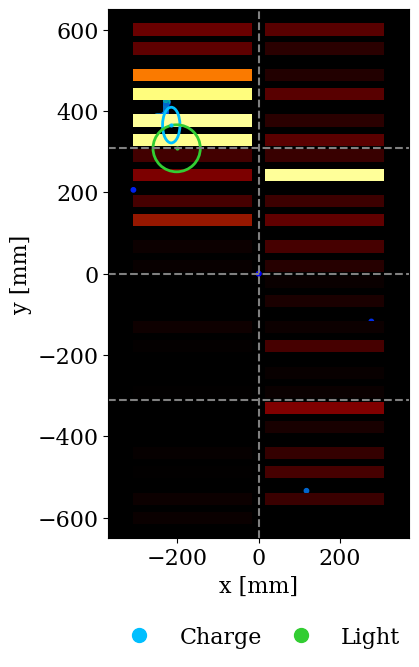

In [518]:

from matplotlib.patches import Rectangle
from matplotlib import cm
cmap = cm.afmhot
alpha = 1



fig, ax = plt.subplots(figsize=(14,7),facecolor='white',dpi=100)
for sn in llc.viable_sn:
    for ch in llc.viable_ch:
        x,y,l_tpc = llc.channelInfo[sn][ch][0],llc.channelInfo[sn][ch][1],llc.channelInfo[sn][ch][3]
        if l_tpc==tpc:
            integ = integs[sn][ch]
            color = cmap((integ/float(max_i[sn]))*0.8)
            ax.add_patch(Rectangle((x,y-15),-(x*0.95),30,facecolor=color,fill=True,alpha=alpha))
            
            
myHits = cdata['hits'][cdata['events'][evid]['hit_ref']]
cmap = plt.cm.get_cmap('winter')
norm = matplotlib.colors.Normalize(vmin=0,vmax=200, clip=True)
ax.scatter(myHits['px'],myHits['py'],c=cmap(norm(myHits['q'])),s=10)
ax.plot(-1e10,-1e10,ls='None',marker='o',markersize=10,color='deepskyblue',label='Charge')
ax.plot(-1e5,-1e5,ls='None',marker='o',markersize=10,color='limegreen',label='Light')
ax.plot(bary_x,bary_y,marker='o',markersize=2,color='deepskyblue')
ax.plot(lbary_x,lbary_y,marker='o',markersize=2,color='limegreen')
ax.add_patch(Ellipse((bary_x,bary_y),width=bary_x_std/2.,height=bary_y_std/2.,facecolor='None',edgecolor='deepskyblue',linewidth=2))
ax.add_patch(Ellipse((lbary_x,lbary_y),width=lbary_x_std/2.,height=lbary_y_std/2.,facecolor='None',edgecolor='limegreen',linewidth=2))



    
plt.xlim(-370,370)
plt.ylim(-650,650)
plt.axvline(0,ls='--',color='gray')
plt.axhline(310.2,ls='--',color='gray')
plt.axhline(0,ls='--',color='gray')
plt.axhline(-310.2,ls='--',color='gray')

plt.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0, frameon=False)



ax.set_facecolor('black')
ax.set_aspect('equal')

plt.xlabel('x [mm]')
plt.ylabel('y [mm]')




plt.show()




